# 楽曲分析(フレーム分析)

## 必要なライブラリのインポート

In [2]:
# ファイルを開いたら一番最初に実行してください
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import librosa
import librosa.display
import IPython
import pandas as pd
import time
import seaborn as sns
import umap
import re

from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout, Attention, Concatenate

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from skmultilearn.model_selection import IterativeStratification

/Users/kenta4610/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-04 14:09:39.101821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## データの読み込み & 加工

In [3]:
# 各曲ごとに特徴量を結合するための関数
def create_feature_array(df):
    feature_arrays = []
    labels = []
    unique_songs = df['Name'].unique()
    
    for song in unique_songs:
        song_df = df[df['Name'] == song]
        
        # 特徴量を抽出してNumPy配列に変換
        features = song_df.drop(columns=['Name', 'Label', 'Feature']).values
        # 特徴量が横方向に並ぶように変形 (時間ステップ, 特徴量数)
        features_reshaped = features.T
        # リストに追加
        feature_arrays.append(features_reshaped)
        # ラベルを追加 (すべての特徴量で同じなので、最初のラベルを使用)
        labels.append(song_df['Label'].iloc[0])
    
    return np.array(feature_arrays), np.array(labels)

In [4]:
file_paths = ['joyful_data.csv', 'fearful_data.csv', 'sorrowful_data.csv', 'relaxing_data.csv']
data_list = [pd.read_csv('./feature_data/'+file_path) for file_path in file_paths]
df = pd.concat(data_list, ignore_index=True)
df = df.fillna(0)

In [5]:
# 各特徴量に対して正規化を適用
scaler = StandardScaler()
feature_names = df['Feature'].unique()
for feature in feature_names:
    if feature != 'Spectral':
        tmp = df[df['Feature'] == feature].iloc[:, 3:]
        normalized_tmp = scaler.fit_transform(tmp)
        df.loc[df['Feature'] == feature, df.columns[3:]] = normalized_tmp

# 特徴量とラベルを整形
X, y = create_feature_array(df)
X = X.transpose(0, 2, 1)
# データの形状を確認
X.shape, y.shape

((200, 113, 2584), (200,))

## クラスタリングで考察

/Users/kenta4610/anaconda3/envs/myenv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/kenta4610/anaconda3/envs/myenv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/kenta4610/anaconda3/envs/myenv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


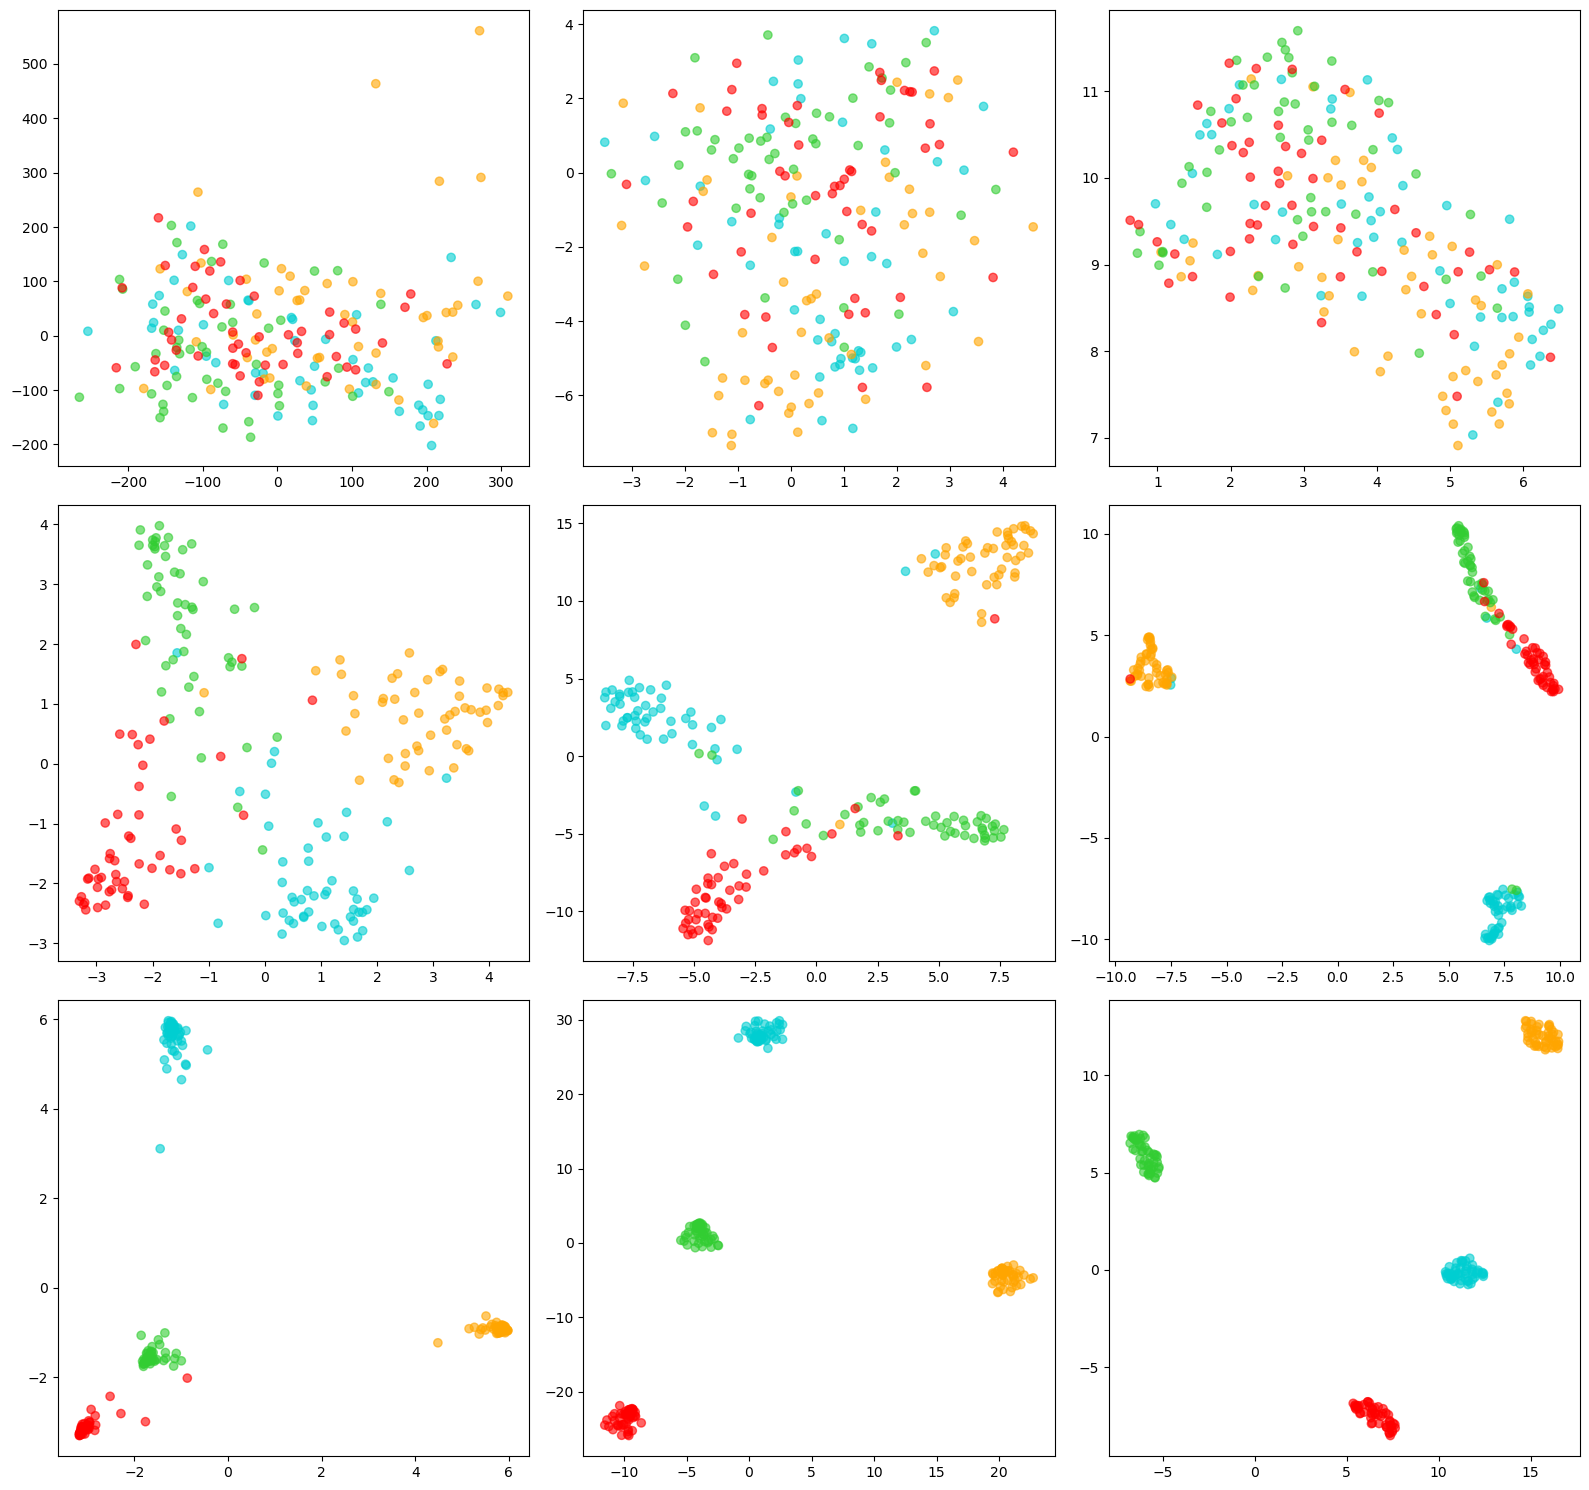

In [14]:
# カスタムカラーマップを作成
colors = ['#00CED1', 'orange', 'limegreen', 'red']
cmap = mcolors.ListedColormap(colors)

# 元データの準備
reshaped_X = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(reshaped_X)

# LSTMデータの読み込みと前処理
loaded_data = np.load('all_prob_lstm.npy')
n = 100
indices = np.random.choice(loaded_data.shape[3], n, replace=False)
selected_data = loaded_data[..., indices]
ave_prob = np.mean(selected_data, axis=3)
flattened_lstm_data = ave_prob.reshape(200, -1)

# GRUデータの読み込みと前処理
loaded_data = np.load('all_prob_gru.npy')
indices = np.random.choice(loaded_data.shape[3], n, replace=False)
selected_data = loaded_data[..., indices]
ave_prob = np.mean(selected_data, axis=3)
flattened_gru_data = ave_prob.reshape(200, -1)

# 次元削減手法のリスト
methods = [
    ('PCA', PCA(n_components=2, random_state=1)),
    ('t-SNE', TSNE(n_components=2, random_state=1)),
    ('UMAP', umap.UMAP(n_components=2, random_state=1))
]

# 次元削減とプロット
fig, axes = plt.subplots(3, 3, figsize=(16, 15))  # 3行3列のグリッド

for i, (name, model) in enumerate(methods):
    # 次元削減
    reduced_original_data = model.fit_transform(scaled_X)
    reduced_lstm_data = model.fit_transform(flattened_lstm_data)
    reduced_gru_data = model.fit_transform(flattened_gru_data)
    
    # 感情ラベルに基づく色分けのプロット（カスタムカラーを使用）
    axes[0, i].scatter(reduced_original_data[:, 0], reduced_original_data[:, 1], c=y, cmap=cmap, marker='o', alpha=0.6)

    axes[1, i].scatter(reduced_lstm_data[:, 0], reduced_lstm_data[:, 1], c=y, cmap=cmap, marker='o', alpha=0.6)

    axes[2, i].scatter(reduced_gru_data[:, 0], reduced_gru_data[:, 1], c=y, cmap=cmap, marker='o', alpha=0.6)

plt.tight_layout()
plt.savefig('clustering.png')
plt.show()

## 感情の起伏があると予測される曲を見つける

music number:  163


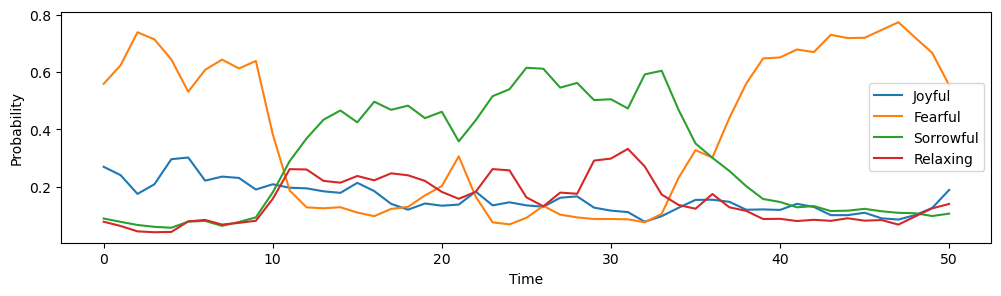

In [23]:
# 保存した予測確率のロード
loaded_data = np.load('all_prob_lstm.npy')

n = 100
indices = np.random.choice(loaded_data.shape[3], n, replace=False)
selected_data = loaded_data[..., indices]
ave_prob = np.mean(selected_data, axis=3)

# 予測結果と実際のラベルのプロット
music_number = 163
print('music number: ', music_number)
path = ''
if music_number <= 50:
    path = 'music_data/joyful/joyful' + str(music_number) + '.mp3'
elif music_number <= 100:
    path = 'music_data/fearful/fearful' + str(music_number%51) + '.mp3'
elif music_number <= 150:
    path = 'music_data/sorrowful/sorrowful' + str(music_number%51) + '.mp3'
else:
    path = 'music_data/relaxing/relaxing' + str(music_number%51) + '.mp3'

# music_data: 2次元配列、形状は (感情ラベル数, フレーム数)
music_data = ave_prob[music_number-1]

joyful_probabilities = music_data[0]
fearful_probabilities = music_data[1]
sorrowful_probabilities = music_data[2]
relaxing_probabilities = music_data[3]

# 感情の確率のプロット
plt.figure(figsize=(12, 3))
plt.plot(joyful_probabilities, label='Joyful')
plt.plot(fearful_probabilities, label='Fearful')
plt.plot(sorrowful_probabilities, label='Sorrowful')
plt.plot(relaxing_probabilities, label='Relaxing')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

y, sr = librosa.load(path, offset=0.0, duration=60.0)
IPython.display.Audio(y, rate=sr)